In [1]:

# --- Set cores and seed ---
import os
N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"

# --- Import Libraries ---
import jax.numpy as jnp
import jax

print(jax.devices(), jax.device_count())

import pandas as pd
import numpy as np
import pyreadr

from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.optim import ClippedAdam
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, AutoNormal
import numpyro.distributions as dist
import numpyro

import matplotlib.pyplot as plt

import src.utils as utils

import Data.Palluck_et_al.data_wrangle as dw



[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)] 4


In [2]:
all_schools = pyreadr.read_r('Data/Palluck_et_al/37070-0001-Data.rda')
all_schools = pd.DataFrame(all_schools['da37070.0001'])

df_cleaned = dw.clean_data(all_schools)

print(df_cleaned.shape)
print(df_cleaned.columns)

(24182, 41)
Index(['SCHID', 'SCHTREAT_NUMERIC', 'TREAT_NUMERIC', 'unique_id', 'ELIGIBLE',
       'WRISTOW2_NUMERIC', 'ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7',
       'ST8', 'ST9', 'ST10', 'ST1W2', 'ST2W2', 'ST3W2', 'ST4W2', 'ST5W2',
       'ST6W2', 'ST7W2', 'ST8W2', 'ST9W2', 'ST10W2', 'BF1', 'BF2', 'BF1W2',
       'BF2W2', 'GENC', 'ETHW', 'ETHB', 'ETHH', 'ETHA', 'ETHC', 'ETHSA',
       'GAME', 'GRC_6', 'GRC_7', 'GRC_8'],
      dtype='object')


In [3]:
df_cleaned

,SCHID,SCHTREAT_NUMERIC,TREAT_NUMERIC,unique_id,ELIGIBLE,WRISTOW2_NUMERIC,ST1,ST2,ST3,ST4,...,ETHW,ETHB,ETHH,ETHA,ETHC,ETHSA,GAME,GRC_6,GRC_7,GRC_8
0,1.0,1,0,1001,0,0,12.0,999.0,140.0,13.0,...,1,0,0,0,0,0,1,1,0,0
1,1.0,1,2,1002,1,0,21.0,31.0,7.0,20.0,...,1,0,0,0,0,0,1,1,0,0
2,1.0,1,0,1003,0,0,999.0,1.0,45.0,20.0,...,1,0,0,0,0,0,1,1,0,0
3,1.0,1,0,1004,0,1,19.0,24.0,32.0,22.0,...,0,0,1,0,0,0,1,1,0,0
4,1.0,1,0,1005,0,0,258.0,10.0,4.0,32.0,...,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24466,60.0,1,0,60670,0,0,508.0,470.0,405.0,631.0,...,1,0,0,0,0,0,1,0,0,1
24467,60.0,1,0,60671,0,0,194.0,519.0,520.0,NaN,...,0,0,1,0,0,0,1,0,0,1
24468,60.0,1,0,60672,0,0,28.0,161.0,263.0,174.0,...,0,1,0,0,0,0,1,0,0,1
24469,60.0,1,0,60673,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0


In [4]:
df_cleaned["SCHID"].unique()

array([ 1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 53., 55., 56.,
       57., 58., 59., 60.])

In [5]:
# test one school

# df_min = df_cleaned[df_cleaned['SCHID'] == 41.0]
df_min = df_cleaned[df_cleaned['SCHID'].isin([41.0,49.0, 51.0])]
df_min["schid_s"] = dw.transform_schid(jnp.array(df_min["SCHID"].values))
# df_min = df_cleaned[df_cleaned['SCHID'] == 49.0]
print(df_min.shape)

(1459, 42)


C:\Users\bar21\AppData\Local\Temp\ipykernel_16216\4199859493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min["schid_s"] = dw.transform_schid(jnp.array(df_min["SCHID"].values))


In [6]:
a_triu, ij_idx = dw.network_by_school(df_min[df_min["SCHID"] == 41.0], dw.ST_COLS)
a2_triu, ij_idx2 = dw.network_by_school(df_min[df_min["SCHID"] == 41.0], dw.ST_W2_COLS)
a3_triu, ij_idx3 = dw.network_by_school(df_min[df_min["SCHID"] == 41.0], dw.BF_COLS)
a4_triu, ij_idx4 = dw.network_by_school(df_min[df_min["SCHID"] == 41.0], dw.BF_W2_COLS)

print(a_triu.shape, ij_idx.shape)
print(a2_triu.shape, ij_idx2.shape)
print( a3_triu.shape, ij_idx3.shape)
print(a4_triu.shape, ij_idx4.shape)

(126253,) (126253, 2)
(126253,) (126253, 2)
(126253,) (126253, 2)
(126253,) (126253, 2)


In [7]:
data_dict = dw.data_for_network_analysis(df_min)
# data_dict = dw.data_for_network_analysis(df_cleaned)
# print(df_data.keys())
print(data_dict)


triu_data = dw.network_triu_multiple_schools(df_min)
print(triu_data.keys())

print(triu_data["ST_triu"].shape, triu_data["ij_indices"].shape)

data_dict = data_dict | triu_data



{'n_schools': 3, 'n_nodes_sch': array([503, 409, 547], dtype=int64), 'offsets': Array([  0, 503, 912], dtype=int32), 'total_n': 1459, 'total_edges_list': array([126253,  83436, 149331], dtype=int64), 'total_edges_sum': 359020, 'schid_s': Array([0, 0, 0, ..., 2, 2, 2], dtype=int32)}
dict_keys(['ST_triu', 'STW2_triu', 'BF_triu', 'BFW2_triu', 'ij_indices'])
(359020,) (359020, 2)


In [8]:
%%time 
# df_min_net_cov = cov_for_net(df_min, NODE_COV)
df_min_net_cov = dw.cov_for_net(df_min, dw.COV_FOR_NETWORK)

print(df_min_net_cov.shape, df_min_net_cov.dtype, type(df_min_net_cov))

data_dict["cov"] = jnp.array(df_min_net_cov)

(359020, 5) float32 <class 'jaxlib.xla_extension.ArrayImpl'>
CPU times: total: 5.75 s
Wall time: 5.7 s


In [9]:
print(data_dict["ST_triu"].shape, data_dict["STW2_triu"].shape, data_dict["BF_triu"].shape, data_dict["BFW2_triu"].shape)


(359020,) (359020,) (359020,) (359020,)


In [17]:
data_dict["schid_edges"] = dw.school_id_by_edge(data_dict)
print(data_dict["schid_edges"].shape, "\n",
      jnp.unique_counts(data_dict["offsets"][data_dict["schid_edges"]]), "\n",
      data_dict["offsets"][data_dict["schid_edges"]].shape)

(359020,) 
 _UniqueCountsResult(values=Array([  0, 503, 912], dtype=int32), counts=Array([126253,  83436, 149331], dtype=int32)) 
 (359020,)


In [24]:
data_dict["schid_edges"]

Array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [18]:
PRIOR_SCALE = jnp.sqrt(5.0)

def networks_marg_multi_school(data):
    """
    A fully vectorized multi-school network model in NumPyro.
    Marginalizes out A^1 edges, and uses advanced indexing to 
    avoid Python loops.

    Args:
        data: dict with the following minimal fields
          - 'n_schools': S (int)
          - 'n_nodes_sch': shape [S] 
          - 'offsets': shape [S] (the start index for each school in the concatenated node array)
          - 'total_n': total # of nodes across all schools
          - 'schid_edges': shape [E], school ID for each edge
          - 'ij_indices': shape (E, 2), local indices (i,j) in that school
          - 'cov': shape [E, n_cov], covariates for each edge
          - 'STW2_triu': shape [E], the observed edges A^2_{ij} in upper triangle
    """

    # -------------------------------------------------------
    #  1. Global parameters shared across all schools
    # -------------------------------------------------------
    n_covs = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0.0, PRIOR_SCALE).expand([n_covs]))
    gamma = numpyro.sample("gamma", dist.Normal(0.0, PRIOR_SCALE).expand([2]))

    # Transform them up for sigmoids:
    obs_prob_k0 = jax.nn.sigmoid(gamma[0])  # P(A^STW2=1 | A^ST=0)
    obs_prob_k0 = jnp.clip(obs_prob_k0, a_min=1e-6, a_max=1.0 - 1e-6)
    obs_prob_k1 = jax.nn.sigmoid(gamma[1])  # P(A^STW2=1 | A^ST=1)
    obs_prob_k1 = jnp.clip(obs_prob_k1, a_min=1e-6, a_max=1.0 - 1e-6)


    # -------------------------------------------------------
    #  2. School-level random intercepts
    # -------------------------------------------------------
    alpha = numpyro.sample("alpha", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))
    # or for hierarchical modeling, you could do something like:
    # sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfCauchy(1.0))
    # alpha = numpyro.sample("alpha", dist.Normal(0.0, sigma_alpha).expand([S]))

    # -------------------------------------------------------
    #  3. Node-level latent positions, all schools concatenated
    # -------------------------------------------------------

    with numpyro.plate("all_nodes", data["total_n"]):
        # 1D array of length total_n
        u_all = numpyro.sample("u_all", dist.Normal(0.0, 1.0))

    # -------------------------------------------------------
    #  4. Compute star_probs = P(A^1_{ij}=1) for each edge
    # -------------------------------------------------------
    E = data["STW2_triu"].shape[0]  # total edges stacked

    # We can compute "global" node indices for each edge in a vectorized manner:
    #   global_i[e] = offsets[schid[e]] + i_idx[e]
    #   global_j[e] = offsets[schid[e]] + j_idx[e]
    global_i = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 0]
    global_j = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 1]

    # The distance in latent space for edge e:
    #   dist_term[e] = | u_all[global_i[e]] - u_all[global_j[e]] |
    u_i = u_all[global_i]
    u_j = u_all[global_j]
    u_norm = jnp.abs(u_i - u_j)

    # The linear covariate predictor for edge e:
    #   cov_term[e] = dot(cov[e,:], theta)
    # cov_term = jnp.einsum('ed,d->e', data["cov"], theta)  # shape (E,)
    cov_term = jnp.dot(data["cov"], theta)

    # The school random intercept: alpha_term[e] = alpha[ schid[e] ]
    alpha_term = alpha[data["schid_edges"]]

    # Now combine them into the logit
    star_logit = alpha_term + cov_term - u_norm 
    star_probs = jax.nn.sigmoid(star_logit)  # shape (E,)
    star_probs = jnp.clip(star_probs, a_min=1e-6, a_max=1.0 - 1e-6)

    # -------------------------------------------------------
    #  5. Marginal likelihood for the observed edges A^2
    #     P(A^2=1) = star_probs*obs_prob_k1 + (1 - star_probs)*obs_prob_k0
    # -------------------------------------------------------
    mixed_probs = star_probs * obs_prob_k1 + (1.0 - star_probs) * obs_prob_k0

    with numpyro.plate("edges", E):
        numpyro.sample("obs", dist.BernoulliProbs(mixed_probs), obs=data["STW2_triu"])

    # -------------------------------------------------------
    #  6. Posterior of A^1_{ij} for diagnostic (optional)
    # -------------------------------------------------------
    # posterior_A1_probs[e] = P(A^1=1 | A^2, params).
    #   numerator = star_probs[e]*{obs_prob_k1 if A^2=1 else 1 - obs_prob_k1}
    #   denominator = numerator + (1 - star_probs[e])*{obs_prob_k0 if A^2=1 else 1 - obs_prob_k0}
    at2 = data["STW2_triu"]  # shape (E,)
    numerator_1 = jnp.where(
        at2 == 1.0,
        star_probs * obs_prob_k1,
        star_probs * (1.0 - obs_prob_k1)
    )
    denominator = numerator_1 + jnp.where(
        at2 == 1.0,
        (1.0 - star_probs) * obs_prob_k0,
        (1.0 - star_probs) * (1.0 - obs_prob_k0)
    )
    posterior_A1_probs = numerator_1 / denominator

    numpyro.deterministic("posterior_A1_probs", posterior_A1_probs)


In [ ]:
PRIOR_SCALE = jnp.sqrt(5.0)

def networks_marginalized_model(data):
    """
    Model for network only models with marginalized A*
    Used in cut-posterior sampling

    We embed it as mixture model of A edges

    Args:
      data: an object with attributes:
           - x_diff: a 1D array (one per edge) of differences in covariates,
           - x2_or: a 1D array of indicators (one per edge) for whether x2_i + x2_j = 1,
           - triu_obs: a 1D array of observed edge indicators (binary; one per edge).
    """
    # --- Priors ---

    with numpyro.plate("latent_u", data["n"]):
        u = numpyro.sample("u", dist.Normal(0, 1))
        # u = numpyro.sample("u", dist.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))

    idx = np.triu_indices(n=data["n"], k=1)
    u_diff = u[idx[0]] - u[idx[1]]
    u_norm = jnp.abs(u_diff)

    n_cols = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([n_cols]))
    # with numpyro.plate("theta_plate", n_cols):
        # theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE))
    
    # with numpyro.plate("gamma_plate", n_cols + 1):
        # gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE))

        # P(A*_ij=1)
    # gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2*n_cols]))
    gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2]))

        # P(A*_ij=1)
    # star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_diff)
    star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_norm)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 0)
    # obs_probs_k0 = jax.nn.sigmoid(data["cov"] @ gamma[1:])
    # obs_probs_k0 = jax.nn.sigmoid(data["cov"] @ gamma[:n_cols])
    obs_probs_k0 = jax.nn.sigmoid(gamma[0])
    obs_probs_k0 = jnp.clip(obs_probs_k0, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 1)
    # obs_probs_k1 = jax.nn.sigmoid(gamma[0] + data["cov"] @ gamma[1:])
    # obs_probs_k1 = jax.nn.sigmoid(data["cov"]  @ gamma[n_cols:])
    obs_probs_k1 = jax.nn.sigmoid(gamma[1])
    obs_probs_k1 = jnp.clip(obs_probs_k1, 1e-6, 1 - 1e-6)

    # marginalized probs P(A_ij=1)
    mixed_probs = star_probs * obs_probs_k1 + (1 - star_probs) * obs_probs_k0

    with numpyro.plate("edges", data["STW2_triu"].shape[0]):
        numpyro.sample("obs", dist.BernoulliProbs(mixed_probs), obs=data["STW2_triu"])

    # save posterior A_star probs
    # let  p_1 = P(A*_ij=1)*P(A_ij| A*_ij=1)
    #      p_0 = P(A*_ij=0 )*P(A_ij| A*_ij=0)
    # then posterior probs P(A*_ij | A, \theta,\ gamma) = p_1 / (p_1 + p_0)

    # numerator aka p_1
    numerator = jnp.where(
        data["STW2_triu"] == 1.0, star_probs * obs_probs_k1, star_probs * (1 - obs_probs_k1)
    )
    # denominator aka p_1 + p_0
    denominator = numerator + jnp.where(
        data["STW2_triu"] == 1.0,
        (1 - star_probs) * obs_probs_k0,
        (1 - star_probs) * (1 - obs_probs_k0),
    )

    numpyro.deterministic("triu_star_probs", numerator / denominator)



In [9]:

def networks_marginalized_model_rep(data):
    """
    Model for network only models with marginalized A*
    Used in cut-posterior sampling

    We have repeated proxy measures A^r, A

    We embed it as mixture model of (A^r, A) edges (4 categories)

    Args:
      data: an object with attributes:
           - x_diff: a 1D array (one per edge) of differences in covariates,
           - x2_or: a 1D array of indicators (one per edge) for whether x2_i + x2_j = 1,
           - triu_obs: a 1D array of observed edge indicators (binary; one per edge).
           - triu_obs_rep: a 1D array of repeated observed edge indicators (binary; one per edge).
    """

    # latent positions
    with numpyro.plate("latent_u", data["n"]):
        u = numpyro.sample("u", dist.Normal(0, 1))
        # u = numpyro.sample("u", dist.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))

    idx = np.triu_indices(n=data["n"], k=1)
    u_diff = u[idx[0]] - u[idx[1]]
    u_norm = jnp.abs(u_diff)

    # priors
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([2]))
    gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([7]))

    # P(A*_ij=1)
    star_probs = jax.nn.sigmoid(theta[0] + theta[1] * data.x2_or)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 1)
    obs_probs_k1 = jax.nn.sigmoid(gamma[0])
    obs_probs_k1 = jnp.clip(obs_probs_k1, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 0)
    obs_probs_k0 = jax.nn.sigmoid(gamma[1] + gamma[2] * data.x_diff)
    obs_probs_k0 = jnp.clip(obs_probs_k0, 1e-6, 1 - 1e-6)

    # P(A^r_ij=1 | A*_ij=1, A_ij)
    obs_rep_probs_k1 = jax.nn.sigmoid(gamma[3] + gamma[4] * data.triu_obs)
    obs_rep_probs_k1 = jnp.clip(obs_rep_probs_k1, 1e-6, 1 - 1e-6)

    # P(A^r_ij=1 | A*_ij=0, A_ij)
    obs_rep_probs_k0 = jax.nn.sigmoid(gamma[5] + gamma[6] * data.triu_obs)
    obs_rep_probs_k0 = jnp.clip(obs_rep_probs_k0, 1e-6, 1 - 1e-6)

    # compute marginalize probs of (A^_ij=r, A_ij=a), a,r \in {0,1}
    # represent as categorical $C_ij = 2 A_ij + A^r_ij \in {0,1,2,3}
    # Given A*_ij=1
    # p(A_ij=r, A^r_ij=a | A*_ij=1)*P(A*_ij=1)
    pj_star1_cat0 = star_probs * (1 - obs_probs_k1) * (1 - obs_rep_probs_k1)
    pj_star1_cat1 = star_probs * (1 - obs_probs_k1) * obs_rep_probs_k1
    pj_star1_cat2 = star_probs * obs_probs_k1 * (1 - obs_rep_probs_k1)
    pj_star1_cat3 = star_probs * obs_probs_k1 * obs_rep_probs_k1

    # Given A*_ij=0
    # p(A_ij=r, A^r_ij=a | A*_ij=0)*P(A*_ij=0)
    pj_star0_cat0 = (1 - star_probs) * (1 - obs_probs_k0) * (1 - obs_rep_probs_k0)
    pj_star0_cat1 = (1 - star_probs) * (1 - obs_probs_k0) * obs_rep_probs_k0
    pj_star0_cat2 = (1 - star_probs) * obs_probs_k0 * (1 - obs_rep_probs_k0)
    pj_star0_cat3 = (1 - star_probs) * obs_probs_k0 * obs_rep_probs_k0

    # marginalized probs P(C_ij=c) = \sum_{0,1} p(A_ij=r, A^r_ij=a | A*_ij=k)*P(A*_ij=k)
    p_cat0 = pj_star1_cat0 + pj_star0_cat0
    p_cat1 = pj_star1_cat1 + pj_star0_cat1
    p_cat2 = pj_star1_cat2 + pj_star0_cat2
    p_cat3 = pj_star1_cat3 + pj_star0_cat3

    probs = jnp.stack([p_cat0, p_cat1, p_cat2, p_cat3], axis=-1)
    probs = probs / jnp.sum(probs, axis=-1, keepdims=True)

    # observed categorical data
    obs_cat = jnp.astype(2 * data.triu_obs + data.triu_obs_rep, jnp.int32)

    with numpyro.plate("edges", data.triu_obs.shape[0]):
        numpyro.sample("obs_joint", dist.Categorical(probs=probs), obs=obs_cat)

    # --- Compute the posterior probability of A*_ij=1 given the joint observation ---
    # Select the appropriate terms based on the observed category
    # p_1 = p(C_ij = c | A*_ij = 1)p(A*_ij = 1)
    numerator = jnp.where(
        obs_cat == 0,
        pj_star1_cat0,
        jnp.where(
            obs_cat == 1,
            pj_star1_cat1,
            jnp.where(obs_cat == 2, pj_star1_cat2, pj_star1_cat3),
        ),
    )

    # p_0 = p(C_ij = c | A*_ij = 0)p(A*_ij = 0)
    # denom is p_0 + p_1
    denominator = numerator + jnp.where(
        obs_cat == 0,
        pj_star0_cat0,
        jnp.where(
            obs_cat == 1,
            pj_star0_cat1,
            jnp.where(obs_cat == 2, pj_star0_cat2, pj_star0_cat3),
        ),
    )
    # p_1 / (p_0 + p_1)
    posterior_star = numerator / denominator

    # Save the posterior probabilities for A* (for example, on the upper triangle of the network)
    numpyro.deterministic("triu_star_probs", posterior_star)



In [15]:
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")



print("ST vs ST_w2")
binary_contingency_table(data_dict["ST_triu"], data_dict["STW2_triu"])
print("ST vs BF")
binary_contingency_table(data_dict["ST_triu"], data_dict["BF_triu"])
print("ST vs BF_w2")
binary_contingency_table(data_dict["ST_triu"], data_dict["BFW2_triu"])
print("BF vs BF_w2")
binary_contingency_table(data_dict["BF_triu"], data_dict["BFW2_triu"])

ST vs ST_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 348435 | 4615 |
   1    | 4691 | 1279 |
ST vs BF
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 352259 | 791 |
   1    | 5384 | 586 |
ST vs BF_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 352115 | 935 |
   1    | 5638 | 332 |
BF vs BF_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 356686 | 957 |
   1    | 1067 | 310 |


In [19]:
# init_vals = {
#     "theta": jnp.zeros(data_st["cov"].shape[1]),
#     # "gamma": jnp.zeros(data_st["cov"].shape[1] + 1),
#     # "gamma": jnp.zeros(2*data_st["cov"].shape[1]),
#     "gamma": jnp.zeros(2),
# }

# guide = AutoMultivariateNormal(networks_marginalized_model)
# guide = AutoMultivariateNormal(networks_marg_multi_school)
guide = AutoNormal(networks_marg_multi_school)

svi = SVI(
    # model=networks_marginalized_model,
    model=networks_marg_multi_school,
    guide=guide,
    optim=ClippedAdam(0.0005),
    loss=Trace_ELBO(),
)

rng_key = jax.random.PRNGKey(0)
rng_key, _ = jax.random.split(rng_key)

svi_result = svi.run(rng_key=rng_key,
                    num_steps=10000,
                    progress_bar=True,
                    data=data_dict,
                    # init_params=init_vals
                    )
map_params = guide.median(svi_result.params)

print(map_params)

100%|██████████| 10000/10000 [02:48<00:00, 59.24it/s, init loss: 447000.1562, avg. loss [9501-10000]: 30160.7047]


{'theta': Array([-3.8789423 , -0.7162752 , -1.1802331 , -2.59426   , -0.45306888],      dtype=float32), 'gamma': Array([-4.0700383, -3.4594896], dtype=float32), 'alpha': Array([-1.2189782, -2.0504398, -2.2173955], dtype=float32), 'u_all': Array([-0.01648355,  0.14476876, -0.07443603, ...,  0.0120257 ,
        0.0704391 ,  0.03926769], dtype=float32), 'posterior_A1_probs': Array([3.6541023e-05, 1.3187734e-04, 1.3283158e-04, ..., 1.4922615e-05,
       1.5395097e-05, 2.8237610e-05], dtype=float32)}


In [21]:

rng_key, _ = jax.random.split(rng_key)
preds = Predictive(
    model=networks_marg_multi_school,
    guide=guide,
    params=svi_result.params,
    num_samples=1,
)(rng_key, data_dict)

# triu_star_probs = preds["triu_star_probs"][0]
triu_star_probs = preds["posterior_A1_probs"][0]
print(triu_star_probs.shape)

(359020,)


(array([2.95759e+05, 3.21490e+04, 1.42950e+04, 6.45600e+03, 3.96800e+03,
        1.60700e+03, 1.45900e+03, 1.30700e+03, 1.18300e+03, 8.25000e+02,
        1.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 3.00000e+00]),
 array([9.83055997e-07, 7.41191208e-04, 1.48139941e-03, 2.22160760e-03,
        2.96181580e-03, 3.70202400e-03, 4.44223220e-03, 5.18244039e-03,
        5.92264859e-03, 6.66285679e-03, 7.40306498e-03, 8.14327318e-03,
        8.88348091e-03, 9.62368958e-03, 1.03638973e-02, 1.11041060e-02,
        1.18443137e-02, 1.25845224e-02, 1.33247301e-02, 1.40649388e-02,
        1.48051465e-02]),
 <BarContainer object of 20 artists>)

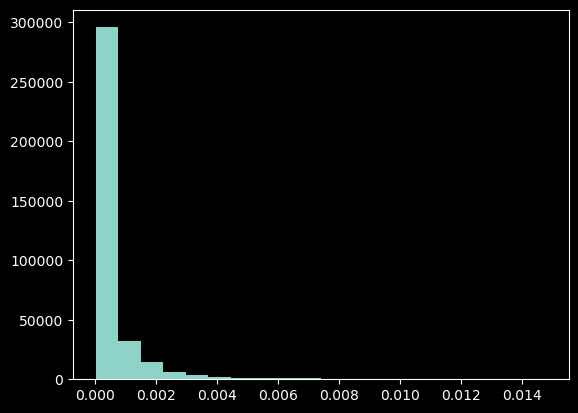

In [22]:
plt.hist(triu_star_probs, bins=20)

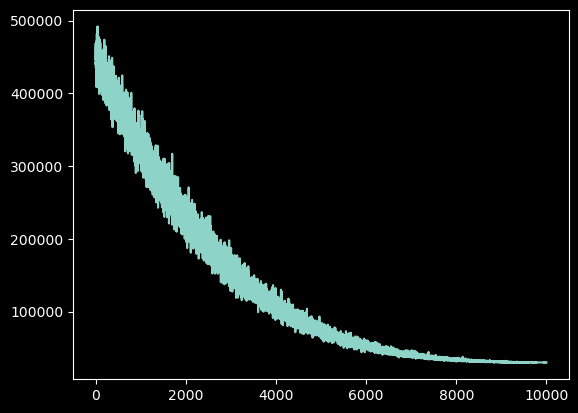

In [23]:
plt.plot(svi_result.losses)

In [25]:
from src.MWG_sampler import sample_posterior_triu_star

post_triu = jnp.array([])
for sch in range(data_dict["n_schools"]):
    sch_probs = triu_star_probs[data_dict["schid_edges"] == sch] 
    rng_key, _ = jax.random.split(rng_key)
    sch_triu = sample_posterior_triu_star(rng_key, sch_probs, 3000)
    post_triu = jnp.concatenate([post_triu, sch_triu], axis=1) if post_triu.size > 0 else sch_triu
    
print(post_triu.shape)

(3000, 359020)


In [33]:
# N = data_dict["total_n"]

# @jax.jit
def triu_to_mat(triu, n):
    mat = jnp.zeros((n, n))
    mat = mat.at[np.triu_indices(n=n, k=1)].set(triu)
    return mat + mat.T

# @jax.jit
def compute_deg(triu, n):
    mat = triu_to_mat(triu, n)
    return jnp.sum(mat, axis=1)

vmap_deg = jax.vmap(compute_deg, in_axes=(0, None))



In [34]:
# true_deg = compute_deg(data_dict["ST_triu"])
# stw2_deg = compute_deg(data_dict["STW2_triu"])
# bf_deg = compute_deg(data_dict["BF_triu"])
# bfw2_deg = compute_deg(data_dict["BFW2_triu"])


true_deg = jnp.array([])
stw2_deg = jnp.array([])
bf_deg = jnp.array([])
bfw2_deg = jnp.array([])
# post_deg = vmap_deg(post_triu)
post_deg = jnp.array([])
for sch in range(data_dict["n_schools"]):
    n_nodes = data_dict["n_nodes_sch"][sch]
    sch_triu = post_triu[:, data_dict["schid_edges"] == sch]
    sch_deg = vmap_deg(sch_triu, n_nodes)
    post_deg = jnp.concatenate([post_deg, sch_deg], axis=1) if post_deg.size > 0 else sch_deg

    sch_true_deg = compute_deg(data_dict["ST_triu"][data_dict["schid_edges"] == sch], n_nodes)
    true_deg = jnp.concatenate([true_deg, sch_true_deg]) if true_deg.size > 0 else sch_true_deg

    sch_stw2_deg = compute_deg(data_dict["STW2_triu"][data_dict["schid_edges"] == sch], n_nodes)  
    stw2_deg = jnp.concatenate([stw2_deg, sch_stw2_deg]) if stw2_deg.size > 0 else sch_stw2_deg

    sch_bf_deg = compute_deg(data_dict["BF_triu"][data_dict["schid_edges"] == sch], n_nodes)
    bf_deg = jnp.concatenate([bf_deg, sch_bf_deg]) if bf_deg.size > 0 else sch_bf_deg

    sch_bfw2_deg = compute_deg(data_dict["BFW2_triu"][data_dict["schid_edges"] == sch],n_nodes)
    bfw2_deg = jnp.concatenate([bfw2_deg, sch_bfw2_deg]) if bfw2_deg.size > 0 else sch_bfw2_deg

print(post_deg.shape, true_deg.shape, stw2_deg.shape, bf_deg.shape, bfw2_deg.shape)


# plt.scatter(true_deg, stw2_deg)


(3000, 1459) (1459,) (1459,) (1459,) (1459,)


cor ST and ST w2 0.4328737
cor ST and Post -0.07544206
cor ST and BF 0.42365143


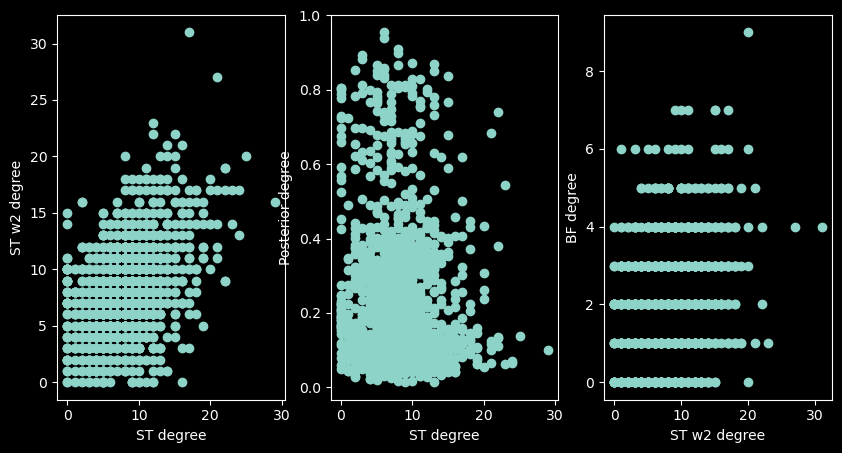

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].scatter(true_deg, stw2_deg)
axs[0].set_xlabel("ST degree")
axs[0].set_ylabel("ST w2 degree")

axs[1].scatter(true_deg, post_deg.mean(axis=0))
axs[1].set_xlabel("ST degree")
axs[1].set_ylabel("Posterior degree")

axs[2].scatter(stw2_deg, bf_deg)
axs[2].set_xlabel("ST w2 degree")
axs[2].set_ylabel("BF degree")

print("cor ST and ST w2", jnp.corrcoef(true_deg, stw2_deg)[0, 1])
print("cor ST and Post", jnp.corrcoef(true_deg, post_deg.mean(axis=0))[0, 1])
print("cor ST and BF", jnp.corrcoef(true_deg, bf_deg)[0, 1])

In [ ]:
# TODO: keep tinkering. options:
# 1. Run models with known st_triu values and perform posterior predictive checks for model fit
# 2. Run model with combined st_w2 and bf proxy networks -- think about these models form and prior p(ST) model 

In [36]:

def prior_model(data):

    n_cols = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([n_cols]))
   
    alpha = numpyro.sample("alpha", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))
    # or for hierarchical modeling, you could do something like:
    # sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfCauchy(1.0))
    # alpha = numpyro.sample("alpha", dist.Normal(0.0, sigma_alpha).expand([S]))

    # -------------------------------------------------------
    #  3. Node-level latent positions, all schools concatenated
    # -------------------------------------------------------

    with numpyro.plate("all_nodes", data["total_n"]):
        # 1D array of length total_n
        u_all = numpyro.sample("u_all", dist.Normal(0.0, 1.0))

    # -------------------------------------------------------
    #  4. Compute star_probs = P(A^1_{ij}=1) for each edge
    # -------------------------------------------------------
    # We can compute "global" node indices for each edge in a vectorized manner:
    #   global_i[e] = offsets[schid[e]] + i_idx[e]
    #   global_j[e] = offsets[schid[e]] + j_idx[e]
    global_i = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 0]
    global_j = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 1]

    # The distance in latent space for edge e:
    #   dist_term[e] = | u_all[global_i[e]] - u_all[global_j[e]] |
    u_i = u_all[global_i]
    u_j = u_all[global_j]
    u_norm = jnp.abs(u_i - u_j)

    # The linear covariate predictor for edge e:
    #   cov_term[e] = dot(cov[e,:], theta)
    # cov_term = jnp.einsum('ed,d->e', data["cov"], theta)  # shape (E,)
    cov_term = jnp.dot(data["cov"], theta)

    # The school random intercept: alpha_term[e] = alpha[ schid[e] ]
    alpha_term = alpha[data["schid_edges"]]

    # Now combine them into the logit
    star_logit = alpha_term + cov_term - u_norm 
    star_probs = jax.nn.sigmoid(star_logit)  # shape (E,)
    star_probs = jnp.clip(star_probs, a_min=1e-6, a_max=1.0 - 1e-6)


    with numpyro.plate("edges", data["cov"].shape[0]):
        numpyro.sample("obs", dist.BernoulliProbs(star_probs), obs=data["ST_triu"])


# run model with svi 

# data_st_prior = {"ST_triu": st_net_triu,
#             "cov": df_min_net_cov,
#             "n" : df_min.shape[0]}

# init_vals = {
#     "theta": jnp.zeros(data_st_prior["cov"].shape[1]),
# }

# guide = AutoMultivariateNormal(prior_model)
# guide = AutoLowRankMultivariateNormal(prior_model)
guide = AutoNormal(prior_model)

svi = SVI(
    model=prior_model,
    guide=guide,
    optim=ClippedAdam(0.0005),
    loss=Trace_ELBO(),
)

# rng_key = jax.random.PRNGKey(5)
rng_key, _ = jax.random.split(rng_key)

svi_result = svi.run(rng_key=rng_key,
                    num_steps=10000,
                    progress_bar=True,
                    data=data_dict,
                    # data=data_st_prior,
                    # init_params=init_vals
                    )

print(svi_result.params)


100%|██████████| 10000/10000 [02:06<00:00, 79.33it/s, init loss: 258069.7188, avg. loss [9501-10000]: 25990.9709]


{'alpha_auto_loc': Array([-3.2906778, -3.285106 , -3.540293 ], dtype=float32), 'alpha_auto_scale': Array([0.03548072, 0.04588184, 0.03648924], dtype=float32), 'theta_auto_loc': Array([-1.8544444 ,  1.0251931 ,  0.2978883 ,  0.02791948,  2.2550278 ],      dtype=float32), 'theta_auto_scale': Array([0.03302318, 0.04827537, 0.03645758, 0.03432175, 0.04962155],      dtype=float32), 'u_all_auto_loc': Array([-1.1152167 , -1.4233291 ,  0.40840447, ...,  2.3824778 ,
        2.375223  , -2.4370859 ], dtype=float32), 'u_all_auto_scale': Array([0.26384124, 0.7035111 , 0.5169357 , ..., 0.6569134 , 0.67927206,
       0.6165721 ], dtype=float32)}


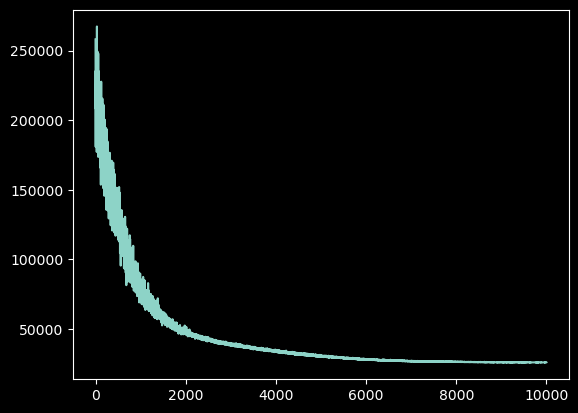

In [37]:
plt.plot(svi_result.losses)

In [38]:

# data_pred = {
#     "ST_triu": None,
#     "cov": df_min_net_cov,
#     "n" : df_min.shape[0]
# }

data_pred = data_dict.copy()
data_pred["ST_triu"] = None

rng_key, _ = jax.random.split(rng_key)
preds_st = Predictive(
    model=prior_model,
    guide=guide,
    params=svi_result.params,
    num_samples=3000,
)(rng_key, data_pred)["obs"]

print(preds_st.shape)

(3000, 359020)


In [39]:
post_deg = jnp.array([])
for sch in range(data_dict["n_schools"]):
    n_nodes = data_dict["n_nodes_sch"][sch]
    sch_triu = preds_st[:, data_dict["schid_edges"] == sch]
    sch_deg = vmap_deg(sch_triu, n_nodes)
    post_deg = jnp.concatenate([post_deg, sch_deg], axis=1) if post_deg.size > 0 else sch_deg

    
print(post_deg.shape,)



(3000, 1459)


cor ST and Post 0.75192356


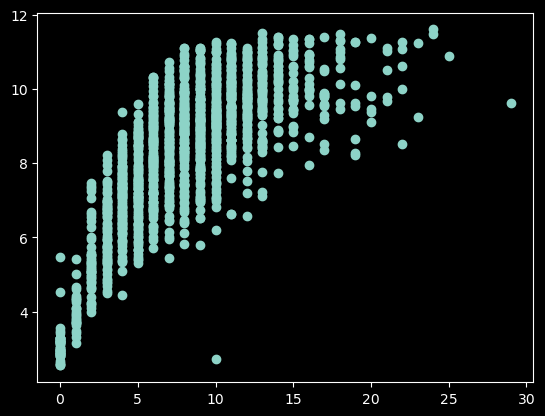

In [40]:
# vmap_pred_deg = vmap_deg(preds_st)
# true_deg = jnp.sum(st_net, axis=1)

plt.scatter(true_deg, post_deg.mean(axis=0))

print("cor ST and Post", jnp.corrcoef(true_deg, post_deg.mean(axis=0))[0, 1])

In [ ]:
# TODO: keep tinkering on multi-schools prior and combined models